
# BBC News Classification
<p>CSCA-5632 Unsupervised Algorithms in Machine Learning</p>
<p>University of Colorado Boulder</p>
<p>@author alme9155@colorado.edu</p>
<hr/>

<h2>I. Project Overview:</h2>
<h3>I.i.Objectives</h3>
<h3>This class project categorizes news articles using matrix factorization to predict the categories. </h3> 

This notebook includes the following:
* Brief EDA procedures
* Matrix factorization model building and training
* Model predictions and results
* Prediction results comparison with Supervised Learning

<h3>I.ii. Project Description</h3>
This project will use a public dataset from the BBC comprised of 2225 articles, each labeled under one of the five categories: business, entertainment, politics, sport, or tech. It is a balanced dataset that. Each category has about 400~500 articles, which ensures meaningful classification.

<ul>
<li>Data source: <a url="https://kaggle.com/competitions/learn-ai-bbc">https://kaggle.com/competition/learn-ai-bbc</a></li>
<li>Bijoy Bose. BBC News Classification</li>
<li>year: 2019</li>
</ul>

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input/competitions/learn-ai-bbc'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitions/learn-ai-bbc/BBC News Train.csv
/kaggle/input/competitions/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/competitions/learn-ai-bbc/BBC News Test.csv


<h2>II. Exploratory Data Analysis</h2>

<h3>II.i.Loading the data from Kaggle competition</h3>
This notebook require internet connection to download dataset from the kaggle competition.

<h3>II.ii.Exploring and understanding the data</h3>
Explore dataset structure and visualize frequency of categories in the BBC dataset.

Data loaded successfully.

Training Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None

Testing Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None

First five rows of training data:
--------------------------
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  busin

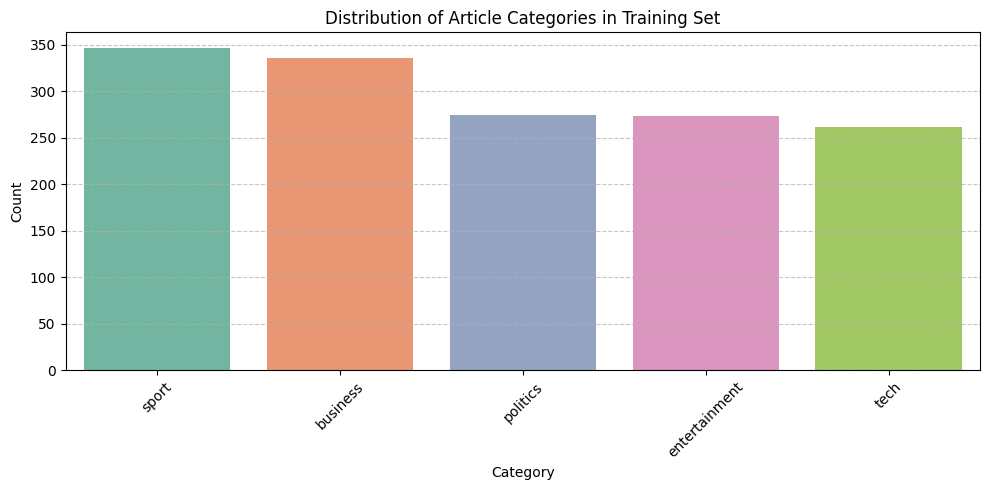

In [2]:
# EDA process
# 1. load the dataset
# 2. inspect the data

## loading the data
train = pd.read_csv('/kaggle/input/competitions/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/competitions/learn-ai-bbc/BBC News Test.csv')
print(f"Data loaded successfully.")

print(f"\nTraining Data Info:")
print("--------------------------")
print(train.info())
print(f"\nTesting Data Info:")
print("--------------------------")    
print(test.info())

print(f"\nFirst five rows of training data:")
print("--------------------------")    
print(train.head())
print(f"\nFirst five rows of testing data:")
print("--------------------------")    
print(test.head())

print(f"\nMissing values in Training Set:")
print("--------------------------")    
print(train.isnull().sum())
print(f"\nMissing Values in Test Set:")
print("--------------------------")    
print(test.isnull().sum())

print("\nArticle Categories")
print("--------------------------")    
unique_categories = train['Category'].unique()
print(f"Unique Article categories:{unique_categories}")
print(f"Number of categories:{len(unique_categories)}")

# histogram to visualize the data
plt.figure(figsize=(10, 5))
sns.countplot(data=train, x='Category', order=train['Category'].value_counts().index, palette='Set2')
plt.title("Distribution of Article Categories in Training Set")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

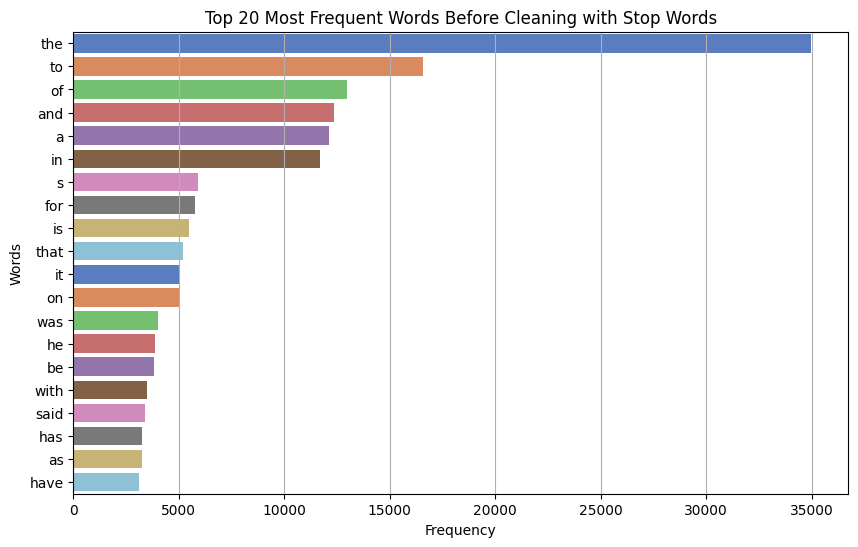

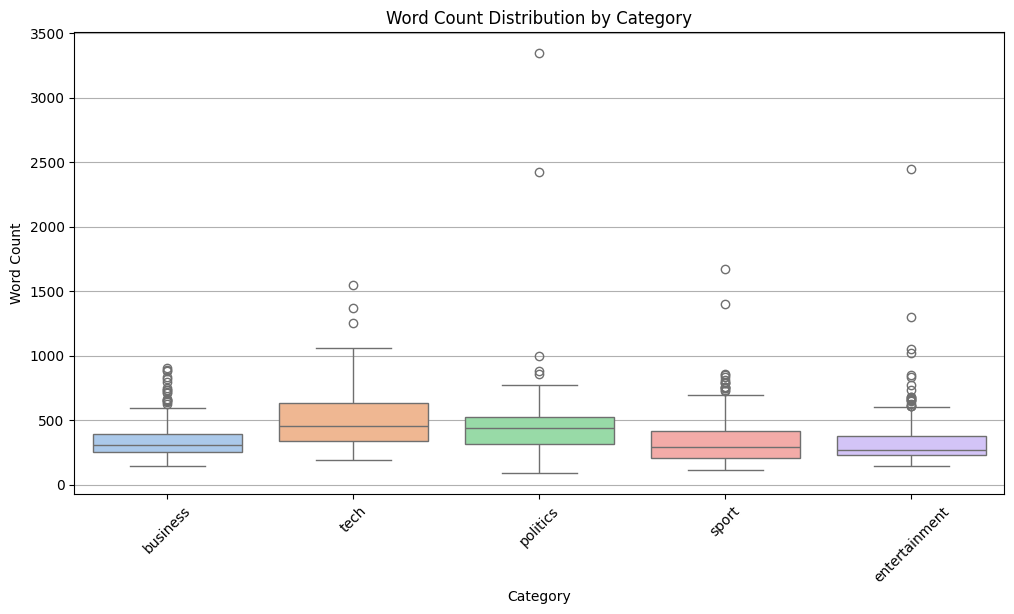

In [3]:
from collections import Counter
# Word counts
word_counts = Counter(' '.join(train['Text']).split())
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words), palette='muted')
plt.title('Top 20 Most Frequent Words Before Cleaning with Stop Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.grid(axis='x')
plt.show()

# Text Length per Category
train['word_count'] = train['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='word_count', data=train, palette='pastel')
plt.title('Word Count Distribution by Category')
plt.xticks(rotation=45)
plt.ylabel('Word Count')
plt.grid(axis='y')
plt.show()

<h2>III. Cleaning and Preparing the data</h2>
Use the Term Frequency-Inverse Document Frequency Vectorizer(TF-IDF) Vectorizer to convert raw text into features tokens.

Built-in function of vectorizer will clean the data with the following steps:
* 1. lower text to lower characters </i>(lowercase=True)</i>
* 2. remove any token with 2 characters or less <i>(r'\b[a-zA-Z]{3,}\b')</i>
* 3. remove all punctuation from string library
* 4. remove all non-meaningful stop words, such as "is", "the", "and", etc.

<b>Expected output:</b>
The Vectorizer will convert raw text into features tokens.
* 1. tokenize the text into words
* 2. count words frequency per documents
* 3. compute TF-IDF scores
* 4. create sparse matrix row=documents, columns=vocabulary word
<pre><code>
For example, <b><i>"mens are from mars, women from Venus"</i></b><br/>
</code>
<code>
<i>(after cleaning and tokenize)</i>
feature names: ["men", "from", "mars", "women", "venus"]<br/>
scores_per_article:[ <br/>
    [0.125, 0.25, 0.125, 0.125, 0.125]<br/>
    ...<br/>
]
</code></pre>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# TF-IDF vectorizer will clean the data:
#
# 1. lower text to lower characters
# 2. tokenize text into words using regex
# 3. remove any token with 2 characters or less. "r'\b[a-zA-Z]{3,}\b'"
# 4. remove all punctuation from string library
# 5. remove all non-meaningful english stop words, such as "is", "the", "and", etc.

# TF-IDF vectorizer with built-in preprocessing
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=5000,
    token_pattern=r'\b[a-zA-Z]{3,}\b'  
)

x_train_tfidf = vectorizer.fit_transform(train['Text'])
x_test_tfidf = vectorizer.transform(test['Text'])

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train['Category'])
print(f"Data are cleaned and pre-processing complete.") 

Data are cleaned and pre-processing complete.


<h2>IV. Apply Matrix factorization and build and train model for prediction</h2>
After tokenization, the new token vector matrix is sparse with 5000 features x 1490 articles.
We will apply Truncated SVD (singular value decomposition) to reduce dimensionality.

Steps:
* 1. Split the TF-IDF train dataset into 80%/20% part.
* 2. Run matrix factorization by setting number of components equals to number of categories (NMF)
* 3. Apply NMF for dimensionality reduction
* 4. Cluster document with the best SVD component (argmax)
* 5. Map each NMF component to a class label
* 6. Predict on validate set using com
* 7. Prepare CSV for submission

Train Accuracy (NMF, n_components=5): 0.892
Test Accuracy (NMF, n_components=5): 0.913

Classification Report:
               precision    recall  f1-score   support

     business       0.90      0.96      0.93        75
entertainment       1.00      0.70      0.82        46
     politics       0.96      0.93      0.95        56
        sport       0.93      1.00      0.96        63
         tech       0.83      0.91      0.87        58

     accuracy                           0.91       298
    macro avg       0.92      0.90      0.91       298
 weighted avg       0.92      0.91      0.91       298



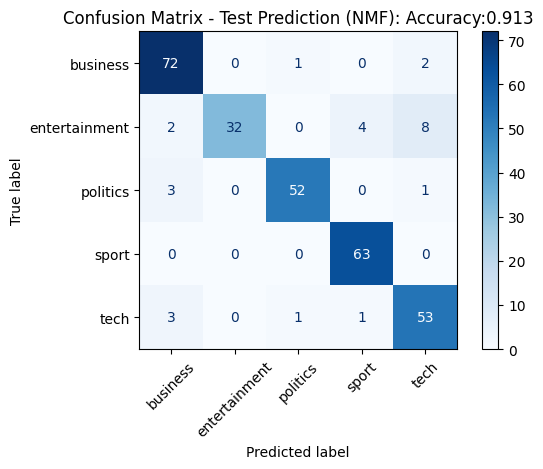

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# split the train dataset to 80%/20% 
x_train, x_validate, y_train_split, y_validate = \
    train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)


# Match latent dimension of NMF with unique number of categories
unique_categories = len(train['Category'].unique())

nmf = NMF(n_components=unique_categories, random_state=42)
x_train_nmf = nmf.fit_transform(x_train)
x_validate_nmf = nmf.transform(x_validate)
x_test_nmf = nmf.transform(x_test_tfidf)

# Find the most frequent category for each NMF feature in training data as category prediction
feature_prediction = np.argmax(x_train_nmf, axis=1)  

used = set()
feature_to_category = {}
# Get the true label for articles 
for component in range(unique_categories):
    if np.isin(component, feature_prediction):
        label = np.bincount(y_train_split[(feature_prediction == component)]).argmax()
        feature_to_category[component] = label
        used.add(label)
    else:
        for i in range(len(le.classes_)):
            if i not in used:
                feature_to_category[component] = i
                used.add(i)
                break
        else:
            feature_to_category[component] = 0 


# Prediction on training
y_pred_train_components = np.argmax(x_train_nmf, axis=1)
y_pred_nmf_train = np.array([feature_to_category[comp] for comp in y_pred_train_components])
score_nmf_train = accuracy_score(y_train_split, y_pred_nmf_train)

# Prediction on testing
y_pred_validate_components = np.argmax(x_validate_nmf, axis=1)
y_pred_nmf = np.array([feature_to_category[comp] for comp in y_pred_validate_components])
score_nmf = accuracy_score(y_validate, y_pred_nmf)

print(f"Train Accuracy (NMF, n_components={unique_categories}): {score_nmf_train:.3f}")
print(f"Test Accuracy (NMF, n_components={unique_categories}): {score_nmf:.3f}")
print("\nClassification Report:")
print(classification_report(y_validate, y_pred_nmf, target_names=le.classes_))

# Confusion Matrix 
cm_nmf = confusion_matrix(y_validate, y_pred_nmf)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_nmf, display_labels=le.classes_)
disp_val.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix - Test Prediction (NMF): Accuracy:{score_nmf:.3f}")
plt.tight_layout()
plt.show()

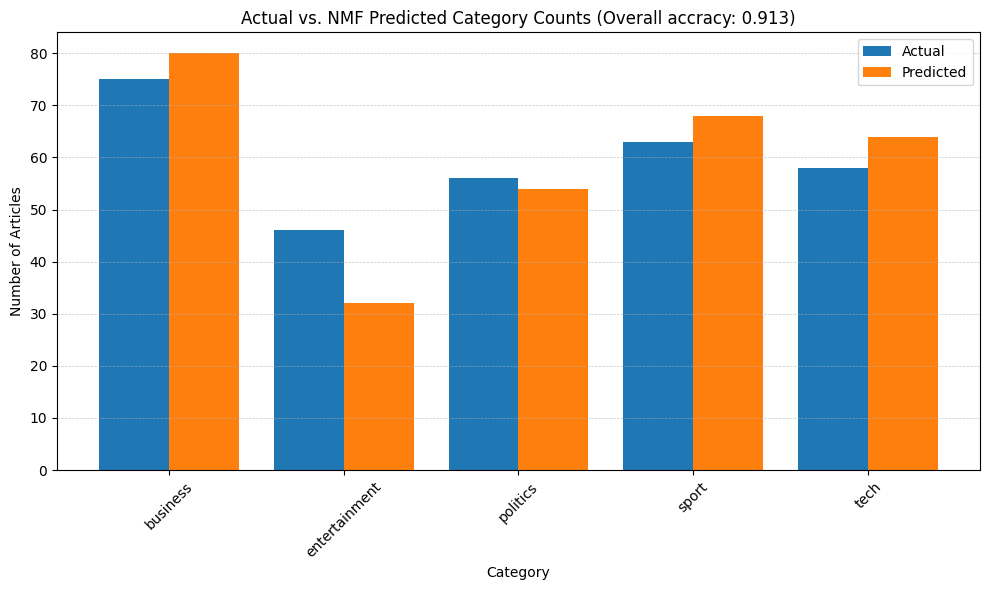

In [6]:
import matplotlib.pyplot as plt

actual_count = pd.Series(y_validate).value_counts().sort_index()
nmf_predicted_count = pd.Series(y_pred_nmf).value_counts().sort_index()

label_name = le.inverse_transform(sorted(actual_count.index))

x = range(len(label_name))
plt.figure(figsize=(10, 6))
plt.bar(x, actual_count, width=0.4, label='Actual', align='center')
plt.bar([i + 0.4 for i in x], nmf_predicted_count, width=0.4, label='Predicted', align='center')
plt.xticks([i + 0.2 for i in x], label_name, rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title(f"Actual vs. NMF Predicted Category Counts (Overall accracy: {score_nmf:.3f})")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.legend()
plt.tight_layout()
plt.show()

<h2>V. Hyper-parameter Tuning with NMF</h2>
Summary table of using different value of word features hyperparameter in TF-IDF vectorizer.

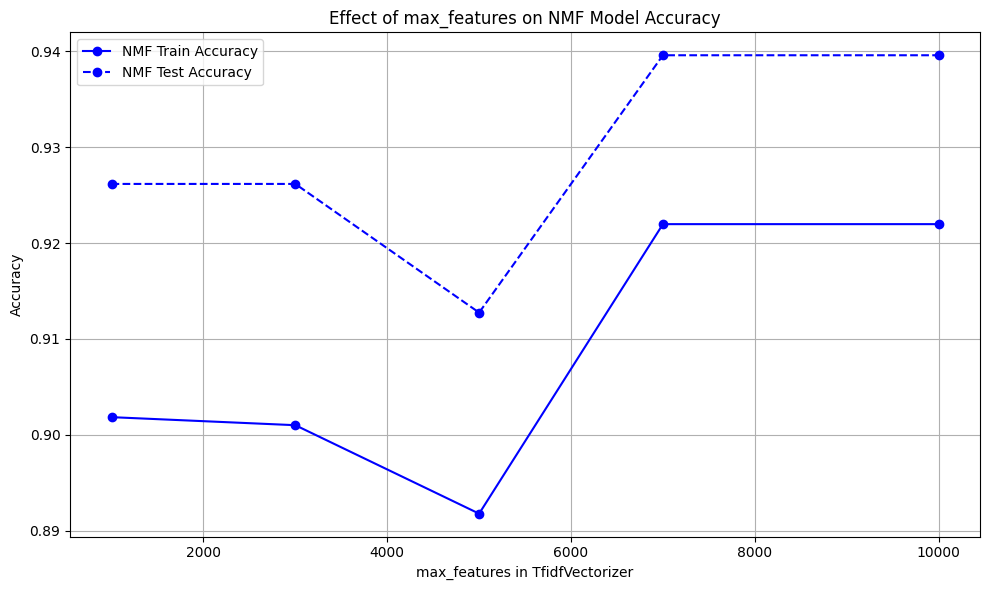

,max_features,train_accuracy,test_accuracy
0,1000,0.901846,0.926174
1,3000,0.901007,0.926174
2,5000,0.891779,0.912752
3,7000,0.921980,0.939597
4,10000,0.921980,0.939597


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


max_features_values = [1000, 3000, 5000, 7000, 10000]
train_accuracy_nmf = []
validate_accuracy_nmf = []
result = []
for max_feature in max_features_values:
    # TF-IDF vectorizer with built-in preprocessing
    # this will ensure number of features liimit to the vocabulary.
    vectorizer = TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        max_features=max_feature,
        token_pattern=r'\b[a-zA-Z]{3,}\b'  
    )
    
    x_train_tfidf = vectorizer.fit_transform(train['Text'])
    x_test_tfidf = vectorizer.transform(test['Text'])
    
    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(train['Category'])
    
    # split the train dataset to 80%/20% 
    x_train, x_validate, y_train_split, y_validate = \
        train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)
    
    
    # Match NMF latent dimension with unique number of categories
    unique_categories = len(train['Category'].unique())    
    nmf = NMF(n_components=unique_categories, random_state=42)
    x_train_nmf = nmf.fit_transform(x_train)
    x_validate_nmf = nmf.transform(x_validate)
    x_test_nmf = nmf.transform(x_test_tfidf)
    
    # Find the most frequent category for each NMF feature in training data as category prediction
    feature_prediction = np.argmax(x_train_nmf, axis=1)  
    
    used = set()
    feature_to_category = {}
    # Get the true label for articles 
    for component in range(unique_categories):
        if np.isin(component, feature_prediction):
            label = np.bincount(y_train_split[(feature_prediction == component)]).argmax()
            feature_to_category[component] = label
            used.add(label)
        else:
            for i in range(len(le.classes_)):
                if i not in used:
                    feature_to_category[component] = i
                    used.add(i)
                    break
            else:
                feature_to_category[component] = 0 
    
    
    # Prediction on training
    y_pred_train_components = np.argmax(x_train_nmf, axis=1)
    y_pred_nmf_train = np.array([feature_to_category[comp] for comp in y_pred_train_components])
    score_nmf_train = accuracy_score(y_train_split, y_pred_nmf_train)
    
    # Prediction on testing
    y_pred_validate_components = np.argmax(x_validate_nmf, axis=1)
    y_pred_nmf = np.array([feature_to_category[comp] for comp in y_pred_validate_components])
    score_nmf = accuracy_score(y_validate, y_pred_nmf)
    train_accuracy_nmf.append(score_nmf_train)
    validate_accuracy_nmf.append(score_nmf)
    result.append((max_feature, score_nmf_train, score_nmf))



# Plotting the results
df = pd.DataFrame(result, columns=['max_features', 'train_accuracy', 'test_accuracy'])
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracy_nmf, 'b-o', label='NMF Train Accuracy')
plt.plot(max_features_values, validate_accuracy_nmf, 'b--o', label='NMF Test Accuracy')
plt.xlabel('max_features in TfidfVectorizer')
plt.ylabel('Accuracy')
plt.title('Effect of max_features on NMF Model Accuracy')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

display(df)


<h3>Hyperparameter Improvement Ideas</h3>
<h3>From Confusion Matrix</h3>
<p>
Reviewing confusion matrix, a few business category is misclassified as tech. A few entertainment words are misclassified into sports and tech.
This misclassification suggests vocabulary overlap among these categories is high.
Possible idea is to find an expert dictionary to remove overlapping words.
This is out-of-scope of this class project</p>

<h3>Improvement with max-feature</h3>
<p>NMF has the best accuracy when feature components are around 7000-10000 (please refer to the chart in section V). Training accuracy drops below 0.90 when the feature component is under 5000. There is no indication of overfitting as the number of feature components increases. This result matches the expectation because this dataset is balanced between different article categories.</p>

<h2>VI. Compare result with supervised learning</h2>

* Using the same 80%/20% split of training data to the Support Vector Machine (SVM) model.
* The SVM model will be validated using different SVM hyper-parameters (e.g., C, kernel, etc).
* We will use the best-trained SVM to make predictions using the test data upon finding the best hyper-parameters.


Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy (SVM): 1.000
Test Accuracy (SVM): 0.973


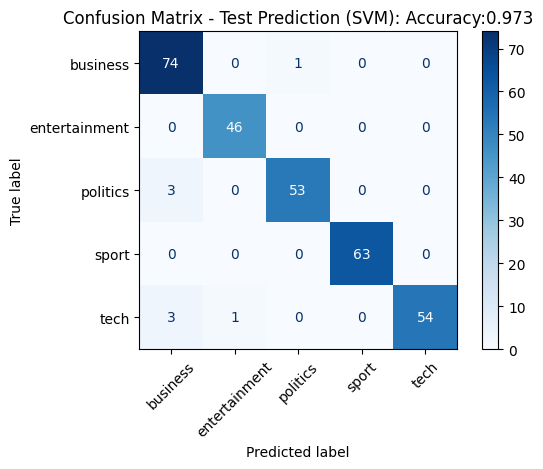

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train, x_validate, y_train_split, y_validate = \
    train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)

# Number of unique categories for NMF components
unique_categories = len(train['Category'].unique())

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] 
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(x_train, y_train_split)
print(f"Best SVM Params: {svm_grid.best_params_}")

# find training accuracy
best_svm = svm_grid.best_estimator_

y_train_pred = best_svm.predict(x_train)
train_accuracy = accuracy_score(y_train_split, y_train_pred)
print(f"Training Accuracy (SVM): {train_accuracy:.3f}")

# find testing accuracy
y_pred_svm = svm_grid.predict(x_validate)
score_svm = accuracy_score(y_validate, y_pred_svm)
print(f"Test Accuracy (SVM): {score_svm:.3f}")

# Confusion Matrix 
cm_svm = confusion_matrix(y_validate, y_pred_svm)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp_val.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix - Test Prediction (SVM): Accuracy:{score_svm:.3f}")
plt.tight_layout()
plt.show()

best_svm = svm_grid.best_estimator_
best_svm.fit(x_train_tfidf, y_train)
test_predictions_svm = best_svm.predict(x_test_tfidf)
test_predictions_svm_label = le.inverse_transform(test_predictions_svm)

submission_svm = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_predictions_svm_label
})
submission_svm.to_csv('svm_submission.csv', index=False)

<h2>VII. SVM Performance Comparison using different train/test percentage</h2>
By changing the train data size (e.g., Include only 10%, 20%, 50% of labels)
<ul>
<li>Observe train/test performance changes. </li>
<li>Observe which methods are data-efficient (require a smaller amount of data to achieve similar results)? </li>
<li>Observe which method will overfit?</li>
</ul>

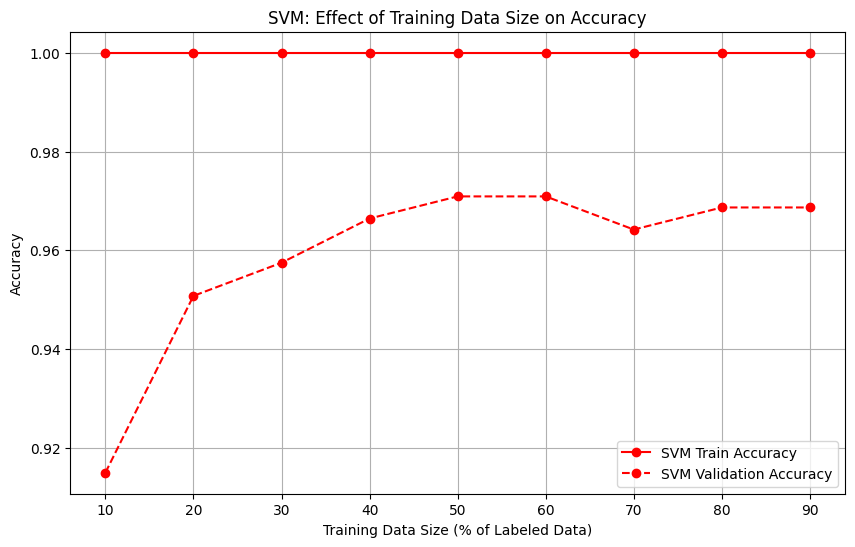

,Train_Size,SVM_Train_Accuracy,SVM_Test_Accuracy
0,0.1%,1.0,0.914989
1,0.2%,1.0,0.950783
2,0.3%,1.0,0.957494
3,0.4%,1.0,0.966443
4,0.5%,1.0,0.970917
5,0.6%,1.0,0.970917
6,0.7%,1.0,0.964206
7,0.8%,1.0,0.968680
8,0.9%,1.0,0.968680


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# List of training data sizes to test
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_accuracy_svm = []
test_accuracy_svm = []
results = []

x_train_full, x_validate, y_train_full, y_validate = train_test_split(
    x_train_tfidf, y_train, test_size=0.3, random_state=42, stratify=y_train
)

for train_size in train_sizes:
    x_train_sub, _, y_train_sub, _ = train_test_split(
        x_train_full, y_train_full, train_size=train_size, random_state=42, stratify=y_train_full
    )
    
    model = SVC(C=10, kernel='linear', gamma='scale')
    model.fit(x_train_sub, y_train_sub) 
    y_train_pred = model.predict(x_train_sub)
    y_pred_val = model.predict(x_validate)
    train_acc = accuracy_score(y_train_sub, y_train_pred)
    validate_acc = accuracy_score(y_validate, y_pred_val)
    
    train_accuracy_svm.append(train_acc)
    test_accuracy_svm.append(validate_acc)
    results.append({
        'Train_Size': f"{train_size:.1f}%",
        'SVM_Train_Accuracy': train_acc,
        'SVM_Test_Accuracy': validate_acc
    })


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([size*100 for size in train_sizes], train_accuracy_svm, 'r-o', label='SVM Train Accuracy')
plt.plot([size*100 for size in train_sizes], test_accuracy_svm, 'r--o', label='SVM Validation Accuracy')
plt.xlabel('Training Data Size (% of Labeled Data)')
plt.ylabel('Accuracy')
plt.title('SVM: Effect of Training Data Size on Accuracy')
plt.grid(True)
plt.legend()
plt.show()
df = pd.DataFrame(results)
display(df)



<h2>VIII. Plot Prediction vs Actual category counts of the best SVM vs NMF model</h2>

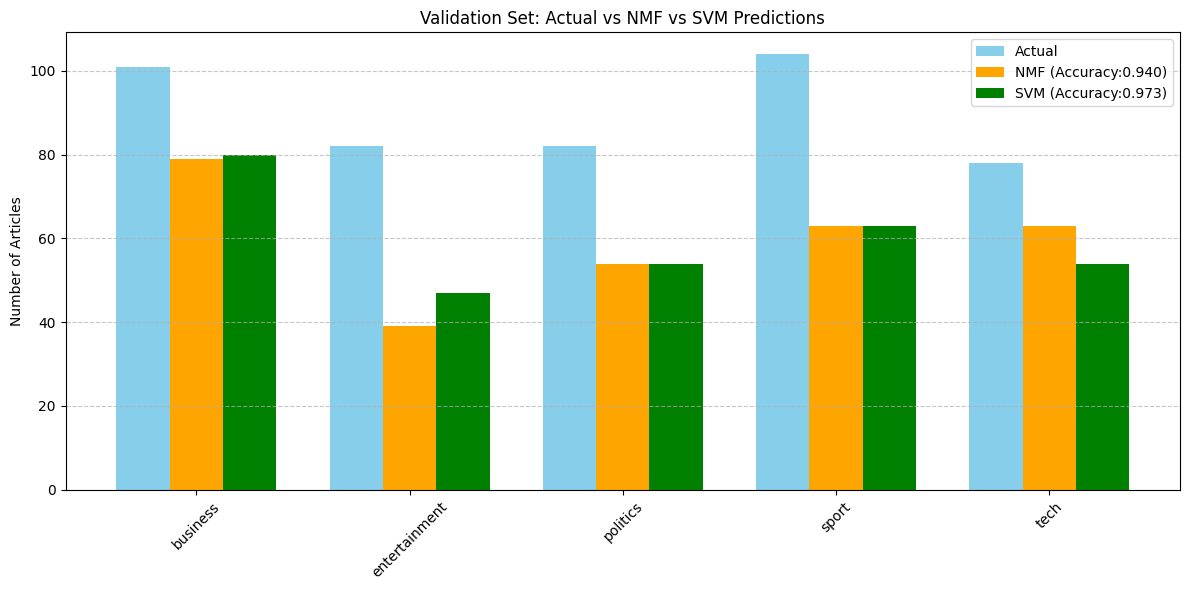

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

label_idx = sorted(set(y_validate)) 
actual_count = pd.Series(y_validate).value_counts().sort_index()
nmf_count = pd.Series(y_pred_nmf).value_counts().sort_index()
svm_count = pd.Series(y_pred_svm).value_counts().sort_index()

actual_count = [actual_count.get(i, 0) for i in label_idx]
nmf_count = [nmf_count.get(i, 0) for i in label_idx]
svm_count = [svm_count.get(i, 0) for i in label_idx]

label_name = le.inverse_transform(label_idx)
x = np.arange(len(label_idx))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 0.25, actual_count, 0.25, label='Actual', color='skyblue')
ax.bar(x, nmf_count, 0.25, label=f"NMF (Accuracy:{score_nmf:.3f})", color='orange')
ax.bar(x + 0.25, svm_count, 0.25, label=f"SVM (Accuracy:{score_svm:.3f})", color='green')

ax.set_xticks(x)
ax.set_xticklabels(label_name, rotation=45)
ax.set_ylabel("Number of Articles")
ax.set_title("Validation Set: Actual vs NMF vs SVM Predictions")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2>IX.Conclusion</h2>

In this notebook, I have predicted the topics of BBC news articles using supervised and unsupervised models. 
* The unsupervised classification model uses Non-negative Matrix Factorization(NMF). 
* The supervised classification model uses a Support Vector Machine (SVM).

<p><b>Prediction Results:</b></p>
Both prediction results perform well with over 90% accuracy
Supervised learning (SVM) performs slightly better than the unsupervised learning model (NMF).

* Best NMF accuracy: 0.940
* Best SVM accuracy: 0.977

<p><b>Prediction Analysis:</b></p>
<p>NMF has the best accuracy when feature components are around 7000-10000 (please refer to the chart in section V). Training accuracy drops below 0.90 when the feature component is under 5000. There is no indication of overfitting as the number of feature components increases. This result matches the expectation because this dataset is balanced between different article categories. </p>

<p>The supervised model provides better accuracy than the unsupervised one. Training accuracy reaches 100%, suggesting the model overfits this small data set, and validation accuracy increases as training data increases. Test accuracy peaks around 50% of the training data increases. After 50% of the training data, there are no more generalizable patterns to learn to improve accuracy. </p>


@author alme9155@colorado.edu <br/>
URL: https://www.kaggle.com/code/alexandermeau/bbc-news-classification/


.

.

In [11]:
# end notebook